In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tqdm import tqdm
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
# raw_dataset = pd.read_csv("/data/fast0/datasets/glathida-3.1.0/data/T.csv")

T_dataset = pd.read_csv("/home/sa42/data/glac/T_models/T.csv")
TT_dataset = pd.read_csv("/home/sa42/data/glac/T_models/TT.csv")
TTT_dataset = pd.read_csv("/home/sa42/data/glac/T_models/TTT.csv")

# T_dataset = pd.read_csv("~/stuff/coding/glacier/data/T.csv")
# TT_dataset = pd.read_csv("~/stuff/coding/glacier/data/TT.csv")
# TTT_dataset = pd.read_csv("~/stuff/coding/glacier/data/TTT.csv")

T_dataset = T_dataset.drop("GLACIER_DB", axis=1)
T_dataset = T_dataset.drop("POLITICAL_UNIT", axis=1)
T_dataset = T_dataset.drop("GLACIER_ID", axis=1)
T_dataset = T_dataset.drop("GLACIER_NAME", axis=1)
T_dataset = T_dataset.drop("NUMBER_OF_SURVEY_POINTS", axis=1)
T_dataset = T_dataset.drop("NUMBER_OF_SURVEY_PROFILES", axis=1)
T_dataset = T_dataset.drop("TOTAL_LENGTH_OF_SURVEY_PROFILES", axis=1)
T_dataset = T_dataset.drop("INTERPOLATION_METHOD", axis=1)
T_dataset = T_dataset.drop("INVESTIGATOR", axis=1)
T_dataset = T_dataset.drop("SPONSORING_AGENCY", axis=1)
T_dataset = T_dataset.drop("ELEVATION_DATE", axis=1)
T_dataset = T_dataset.drop("SURVEY_METHOD_DETAILS", axis=1)
T_dataset = T_dataset.drop("SURVEY_METHOD", axis=1)
T_dataset = T_dataset.drop("SURVEY_DATE", axis=1)
T_dataset = T_dataset.drop("MEAN_THICKNESS", axis=1)
T_dataset = T_dataset.drop("AREA", axis=1)
T_dataset = T_dataset.drop("MEAN_THICKNESS_UNCERTAINTY", axis=1)
T_dataset = T_dataset.drop("MAXIMUM_THICKNESS", axis=1)
T_dataset = T_dataset.drop("MAX_THICKNESS_UNCERTAINTY", axis=1)
T_dataset = T_dataset.drop("DATA_FLAG", axis=1)
T_dataset = T_dataset.drop("REMARKS", axis=1)
T_dataset = T_dataset.drop("REFERENCES", axis=1)
T_dataset = T_dataset.drop("MEAN_SLOPE", axis=1)
T_dataset = T_dataset.dropna()

TT_dataset = TT_dataset.drop("POLITICAL_UNIT", axis=1)
TT_dataset = TT_dataset.drop("GLACIER_NAME", axis=1)
TT_dataset = TT_dataset.drop("SURVEY_DATE", axis=1)
TT_dataset = TT_dataset.drop("MEAN_THICKNESS_UNCERTAINTY", axis=1)
TT_dataset = TT_dataset.drop("MAXIMUM_THICKNESS", axis=1)
TT_dataset = TT_dataset.drop("MAX_THICKNESS_UNCERTAINTY", axis=1)
TT_dataset = TT_dataset.drop("DATA_FLAG", axis=1)
TT_dataset = TT_dataset.drop("REMARKS", axis=1)
TT_dataset = TT_dataset.dropna()

TTT_dataset = TTT_dataset.drop("POLITICAL_UNIT", axis=1)
TTT_dataset = TTT_dataset.drop("GLACIER_NAME", axis=1)
TTT_dataset = TTT_dataset.drop("SURVEY_DATE", axis=1)
TTT_dataset = TTT_dataset.drop("PROFILE_ID", axis=1)
TTT_dataset = TTT_dataset.drop("THICKNESS_UNCERTAINTY", axis=1)
TTT_dataset = TTT_dataset.drop("DATA_FLAG", axis=1)
TTT_dataset = TTT_dataset.drop("REMARKS", axis=1)
TTT_dataset = TTT_dataset.drop("POINT_ID", axis=1)
TTT_dataset = TTT_dataset.dropna()

T = pd.DataFrame(T_dataset)
T.rename(columns = {"LAT":"LAT_CENT",
                    "LON":"LON_CENT",
                    "AREA":"T_AREA"},
         inplace = True)

TT = pd.DataFrame(TT_dataset)
TT.rename(columns = {"LOWER_BOUND":"TT_LOWER_BOUND",
                     "UPPER_BOUND":"TT_UPPER_BOUND",
                     "AREA":"TT_AREA",
                     "MEAN_SLOPE":"TT_MEAN_SLOPE",
                     "MEAN_THICKNESS":"TT_MEAN_THICKNESS"},
          inplace = True)

TTT = pd.DataFrame(TTT_dataset)
TTT.rename(columns = {"ELEVATION":"POINT_ELEVATION",
                      "THICKNESS":"POINT_THICKNESS"},
           inplace = True)

TTT_plu = pd.merge(T, TTT, how="inner", on=["GlaThiDa_ID"])

TTT_plus = pd.merge(TT,TTT_plu, how="inner", on=["GlaThiDa_ID"])
# TTT_plus.dropna()

# TTT_plus

/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (2,4,5,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
#split the dataset into test and train data sets.
train_dataset = TTT_plus.sample(frac=0.8, random_state=1)
test_dataset = TTT_plus.drop(train_dataset.index)

In [4]:
# sns.pairplot(test_dataset[["TT_LOWER_BOUND",
#                             "TT_UPPER_BOUND",
#                             "TT_AREA",
#                             "TT_MEAN_SLOPE",
#                             "TT_MEAN_THICKNESS",
#                             "POINT_LAT",
#                             "POINT_LON",
#                             "POINT_ELEVATION",
#                             "POINT_THICKNESS",
#                             "LAT_CENT",
#                             "LON_CENT"]],
#              diag_kind='kde')

In [5]:
#separate out features - what will be trained to predict desired attribute
train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop("POINT_THICKNESS")
test_labels = test_features.pop("POINT_THICKNESS")

train_features.describe().transpose()[['mean', 'std']]

,mean,std
GlaThiDa_ID,1242.974148,806.029590
TT_LOWER_BOUND,2955.358249,678.468683
TT_UPPER_BOUND,2997.584699,693.106394
TT_AREA,0.422969,0.635959
TT_MEAN_SLOPE,23.090475,9.025714
TT_MEAN_THICKNESS,18.129786,17.766370
LAT_CENT,45.256273,7.522679
LON_CENT,29.987470,36.351443
POINT_LAT,45.256439,7.523287
POINT_LON,29.988477,36.350408


In [6]:
#establish normalization layers
normalizer = {}
variable_list = ("TT_LOWER_BOUND",
                 "TT_UPPER_BOUND",
                 "TT_AREA",
                 "TT_MEAN_THICKNESS",
                 "TT_MEAN_SLOPE",
                 "POINT_LAT",
                 "POINT_LON",
                 "POINT_ELEVATION",
                 "LAT_CENT",
                 "LON_CENT")
for variable_name in variable_list:

    normalizer[variable_name] = preprocessing.Normalization(input_shape=[1,], axis=None)
    normalizer[variable_name].adapt(np.array(train_features[variable_name]))
    
    
normalizer['ALL'] = preprocessing.Normalization(axis=-1)
normalizer['ALL'].adapt(np.array(train_features))

2022-03-14 13:52:50.742363: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-14 13:52:50.742401: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sermeq.ess.washington.edu): /proc/driver/nvidia/version does not exist
2022-03-14 13:52:50.743450: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
def build_linear_model(normalizer):
    model = tf.keras.Sequential([
        normalizer,
        layers.Dense(1)
    ])

    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.001),
        loss="mean_absolute_error")
    
    return model

def plot_single_model_variable(x, y,feature_name):
    plt.scatter(train_features[feature_name], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel(feature_name)
    plt.ylabel("Avg Thickness (m)")
#     plt.xlim((0,20))
    plt.legend()
      
def plot_loss(history):
#     plt.subplots(figsize=(10,5))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #   plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    

In [8]:
test_results = {}
linear_model = {}
linear_history = {}
linear_results = {}

In [9]:
%%time
variable_list = ("TT_LOWER_BOUND",
                 "TT_UPPER_BOUND",
                 "TT_AREA",
                 "TT_MEAN_THICKNESS",
                 "TT_MEAN_SLOPE",
                 "POINT_LAT",
                 "POINT_LON",
                 "POINT_ELEVATION",
                 "LAT_CENT",
                 "LON_CENT")
for variable_name in tqdm(variable_list):

    linear_model[variable_name] = build_linear_model(normalizer[variable_name])
    linear_history[variable_name] = linear_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=100,
                                        verbose=0,
                                        validation_split = 0.2)
    linear_results[variable_name] = linear_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

linear_results

100%|██████████| 10/10 [26:10<00:00, 157.10s/it]

CPU times: user 33min 20s, sys: 2min 14s, total: 35min 34s
Wall time: 26min 11s


{'TT_LOWER_BOUND': 20.663782119750977,
 'TT_UPPER_BOUND': 20.676687240600586,
 'TT_AREA': 23.56426239013672,
 'TT_MEAN_THICKNESS': 20.5421085357666,
 'TT_MEAN_SLOPE': 22.37674331665039,
 'POINT_LAT': 23.57320213317871,
 'POINT_LON': 19.26534080505371,
 'POINT_ELEVATION': 20.291553497314453,
 'LAT_CENT': 23.573339462280273,
 'LON_CENT': 19.264904022216797}

In [10]:
for variable_name in variable_list:    
    df = pd.DataFrame(linear_history[variable_name].history)
    dfs = df.loc[[df.last_valid_index()]]
    dfs.insert(0, 'Variable', [variable_name])
    
    print(dfs)
    print("")


          Variable       loss   val_loss
99  TT_LOWER_BOUND  20.805103  20.650574

          Variable       loss   val_loss
99  TT_UPPER_BOUND  20.819075  20.661163

   Variable       loss   val_loss
99  TT_AREA  23.660885  23.426708

             Variable       loss   val_loss
99  TT_MEAN_THICKNESS  20.686777  20.521381

         Variable       loss   val_loss
99  TT_MEAN_SLOPE  22.500835  22.202427

     Variable       loss   val_loss
99  POINT_LAT  23.676704  23.444809

     Variable       loss   val_loss
99  POINT_LON  19.410795  19.159527

           Variable       loss   val_loss
99  POINT_ELEVATION  20.423601  20.224709

    Variable     loss   val_loss
99  LAT_CENT  23.6768  23.444994

    Variable       loss   val_loss
99  LON_CENT  19.410564  19.159222



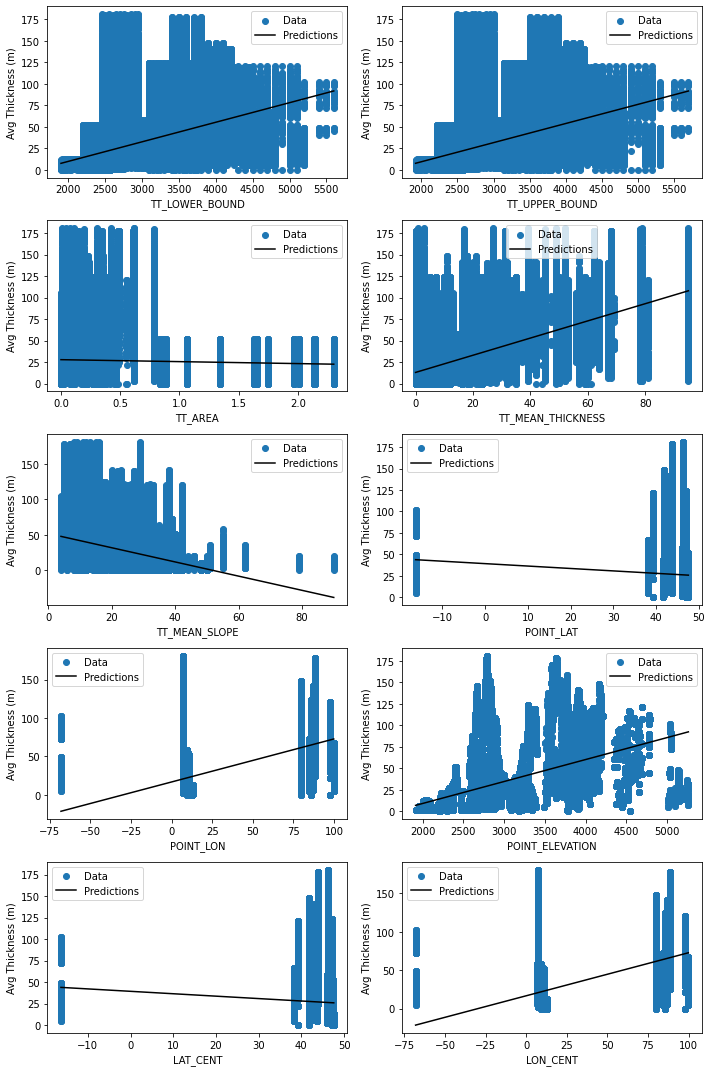

In [11]:
fig,ax=plt.subplots(5,2,figsize=(10,15))
for i, variable_name in enumerate(variable_list):
    plt.subplot(5,2,i+1)
    xmax = np.max(train_features[variable_name])
    xmin = np.min(train_features[variable_name])
    x = tf.linspace(xmin, xmax, 101)
    y = linear_model[variable_name].predict(x)
    plot_single_model_variable(x,y,variable_name)
plt.tight_layout()

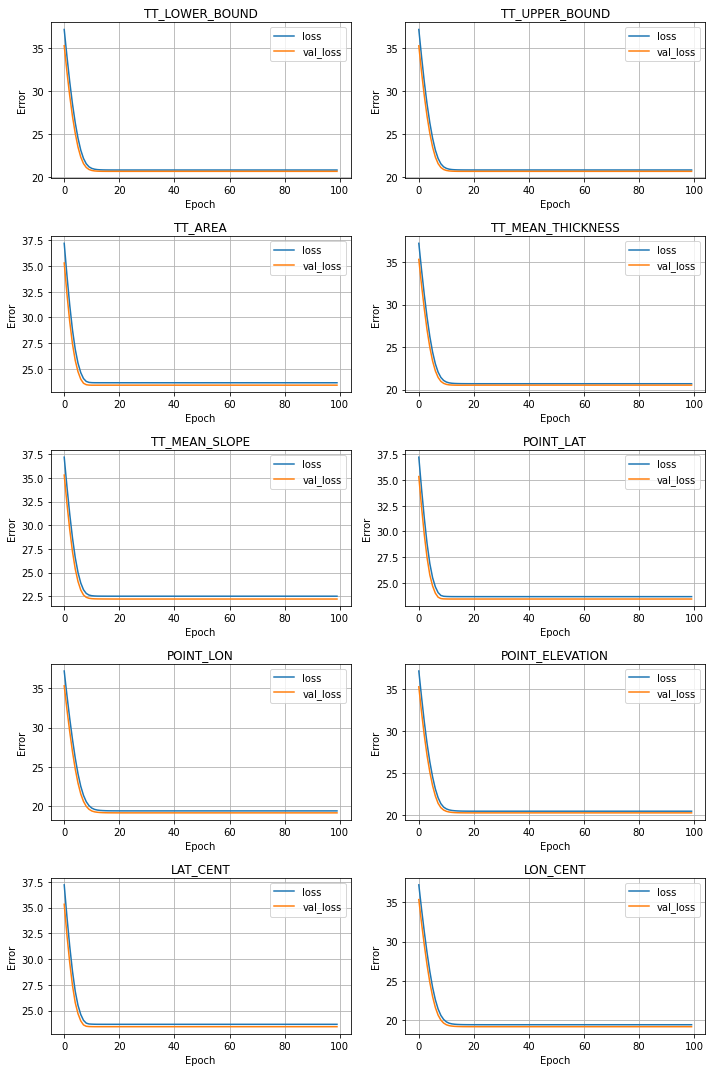

In [12]:
fig,ax=plt.subplots(8,2,figsize=(10,15))
for i, variable_name in enumerate(variable_list):
    ax = plt.subplot(5,2,i+1)

    plt.subplot(5,2,i+1)
    plot_loss(linear_history[variable_name])
    ax.set_title(variable_name)

plt.tight_layout()
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP2_loss.eps")

In [13]:
%%time
linear_model = build_linear_model(normalizer['ALL'])

linear_history_full = linear_model.fit(
train_features, train_labels,        
   epochs=100,
   verbose=0,
   validation_split = 0.2)

test_results["MULTI"] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results

CPU times: user 3min 28s, sys: 15.5 s, total: 3min 44s
Wall time: 2min 42s


{'MULTI': 17.1684513092041}

In [14]:
df = pd.DataFrame(linear_history_full.history)
dfs = df.loc[[df.last_valid_index()]]
dfs.insert(0, 'Variable', 'Multi-Variable')
    
print(dfs)
print("")


          Variable       loss   val_loss
99  Multi-Variable  17.330507  17.163528



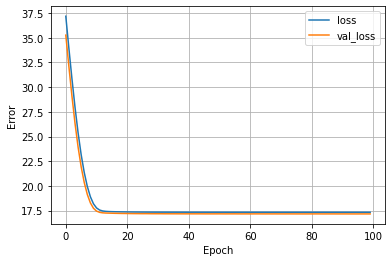

In [15]:
plot_loss(linear_history_full)
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP2_full_loss.eps")

In [16]:
def build_dnn_model(norm):
    model = keras.Sequential([
              norm,
              layers.Dense(64, activation='relu'),
              layers.Dense(64, activation='relu'),
              layers.Dense(1) ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    
    return model

def dnn_test_results(feature_name):
    dnn_test_results[feature_name] = dnn_model.evaluate(
        test_features[feature_name],
        test_labels, verbose=0)

In [17]:
dnn_test_results = {}
dnn_model = {}
dnn_history = {}
dnn_results = {}
dnn_history_full = {}

In [ ]:
%%time
variable_list = ("TT_LOWER_BOUND",
                 "TT_UPPER_BOUND",
                 "TT_AREA",
                 "TT_MEAN_THICKNESS",
                 "TT_MEAN_SLOPE",
                 "POINT_LAT",
                 "POINT_LON",
                 "POINT_ELEVATION",
                 "LAT_CENT",
                 "LON_CENT")
for variable_name in tqdm(variable_list):

    dnn_model[variable_name] = build_dnn_model(normalizer[variable_name])
    dnn_history[variable_name] = dnn_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=100,
                                        verbose=0,
                                        validation_split = 0.2)
    dnn_results[variable_name] = dnn_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

dnn_results

 30%|███       | 3/10 [15:42<36:47, 315.31s/it]

In [ ]:
for variable_name in variable_list:    
    df = pd.DataFrame(dnn_history[variable_name].history)
    dfs = df.loc[[df.last_valid_index()]]
    dfs.insert(0, 'Variable', [variable_name])
    
    print(dfs)
    print("")


In [ ]:
# dnn_results["TT_LOWER_BOUND"]

In [ ]:
fig,ax=plt.subplots(5,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    plt.subplot(5,2,i+1)
    xmax = np.max(train_features[variable_name])
    xmin = np.min(train_features[variable_name])
    x = tf.linspace(xmin, xmax, 101)
    y = dnn_model[variable_name].predict(x)
    plot_single_model_variable(x,y,variable_name)

In [ ]:
fig,ax=plt.subplots(5,2,figsize=(10,15))
for i, variable_name in enumerate(variable_list):
    plt.subplot(5,2,i+1)
    ax = plt.subplot(5,2,i+1)
    ax.set_title(variable_name)
    plot_loss(dnn_history[variable_name])
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP2_dnn_loss.eps")
plt.tight_layout()

In [ ]:
dnn_full_model = build_dnn_model(normalizer['ALL'])

In [ ]:
%%time
dnn_history_full = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, 
    epochs=100)

In [ ]:
df = pd.DataFrame(dnn_history_full.history)
dfs = df.loc[[df.last_valid_index()]]
dfs.insert(0, 'Variable', 'Multi-Variable')
    
print(dfs)
print("")


In [ ]:
plot_loss(dnn_history_full)
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP2_dnn_full_loss.eps")

In [ ]:
dnn_test_results["dnn_full_model"] = dnn_full_model.evaluate(
    test_features,
    test_labels, verbose=0)

dnn_test_results


In [ ]:
y = dnn_full_model.predict(test_features)
plt.plot(test_labels,y,'.')
plt.plot((0,180),(0,180),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness(m)')
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP2_res.EPS")

In [ ]:
predictions = pd.Series(dnn_full_model.predict(test_features).flatten())
testy_testy_test = pd.concat([test_labels,predictions],axis=1)
sns.displot(testy_testy_test, x=test_labels, y=predictions, kind="kde")


In [ ]:
RGI = pd.read_csv("/home/sa42/data/glac/glims/glims_extra/dump2/01_rgi60_Alaska.csv")
RGI = RGI.drop("RGIId", axis=1)
RGI = RGI.drop("GLIMSId", axis=1)
RGI = RGI.drop("BgnDate", axis=1)
RGI = RGI.drop("EndDate", axis=1)
RGI = RGI.drop("O1Region", axis=1)
RGI = RGI.drop("O2Region", axis=1)
# RGI = RGI.drop("Zmin", axis=1)
RGI = RGI.drop("Zmed", axis=1)
# RGI = RGI.drop("Zmax", axis=1)
RGI = RGI.drop("Aspect", axis=1)
RGI = RGI.drop("Lmax", axis=1)
RGI = RGI.drop("Status", axis=1)
RGI = RGI.drop("Connect", axis=1)
RGI = RGI.drop("Form", axis=1)
RGI = RGI.drop("TermType", axis=1)
RGI = RGI.drop("Surging", axis=1)
RGI = RGI.drop("Linkages", axis=1)
RGI = RGI.drop("Name", axis=1)
RGI.rename(columns = {"CenLon":"LON_CENT",
                      "CenLat":"LAT_CENT",
                      "Area":"TT_AREA",
                      "Slope":"TT_MEAN_SLOPE",
                      "Zmin":"TT_LOWER_BOUND",
                      "Zmax":"TT_UPPER_BOUND",},
           inplace = True)
RGI

In [ ]:
y_alaska_test = dnn_full_model.predict(RGI)


In [ ]:
("TT_LOWER_BOUND",
                 "TT_UPPER_BOUND",
                 "TT_AREA",
                 "TT_MEAN_THICKNESS",
                 "TT_MEAN_SLOPE",
                 "POINT_LAT",
                 "POINT_LON",
                 "POINT_ELEVATION",
                 "LAT_CENT",
                 "LON_CENT")